# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [16]:
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_sample_weight
import hopsworks
import numpy as np
from functions import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [17]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
# os.environ["HOPSWORKS_API_KEY"] = ""

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159320
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [18]:
# Retrieve feature groups
air_quality_fg_new = fs.get_feature_group(
    name='air_quality_improved',
    version=1,
)
weather_fg_new = fs.get_feature_group(
    name='weather_improved',
    version=1,
)

In [19]:
air_quality_fg_new.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.54s) 


,date,pm25,country,city,street,url,pm25_rolling_mean_3d,pm25_rolling_std_3d,pm25_rolling_max_3d,pm25_rolling_mean_7d,...,pm25_ema_7d,pm25_trend_3d,pm25_volatility_3d,pm25_trend_7d,pm25_volatility_7d,pm25_trend_14d,pm25_volatility_14d,pm25_zscore,pm25_percentile,pm25_skew_7d
0,2023-05-31 00:00:00+00:00,105.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,108.666667,8.144528,118.0,111.571429,...,110.501333,-1.333333,0.074950,-5.928571,0.084374,16.678571,0.092975,0.720566,0.743028,-0.308756
1,2022-05-27 00:00:00+00:00,69.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,67.000000,7.211103,73.0,66.428571,...,67.243382,-2.333333,0.107628,-3.928571,0.153237,1.285714,0.209159,-0.943490,0.188247,-0.541525
2,2024-09-23 00:00:00+00:00,84.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,95.000000,11.000000,106.0,87.428571,...,90.384138,4.166667,0.115789,-1.642857,0.159975,-0.214286,0.139076,-0.250133,0.442231,-0.294547
3,2024-05-15 00:00:00+00:00,106.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,113.333333,10.214369,125.0,100.428571,...,106.031802,12.833333,0.090127,-8.357143,0.149123,14.571429,0.140902,0.766790,0.755976,0.218035
4,2022-04-14 00:00:00+00:00,98.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,104.666667,14.224392,121.0,92.000000,...,96.146481,10.166667,0.135902,2.785714,0.168858,-0.428571,0.146093,0.397000,0.662849,0.738984
5,2024-04-06 00:00:00+00:00,64.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,70.333333,6.027714,76.0,74.000000,...,73.168019,2.333333,0.085702,-6.642857,0.235358,-3.500000,0.186012,-1.174609,0.117032,1.309725
6,2023-04-11 00:00:00+00:00,81.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,81.333333,6.506407,88.0,94.571429,...,88.035117,-9.833333,0.079997,2.642857,0.182317,-3.107143,0.211211,-0.388805,0.404382,0.571443
7,2022-05-22 00:00:00+00:00,79.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,61.333333,15.695010,79.0,71.000000,...,68.461823,-9.166667,0.255897,0.500000,0.288647,-0.035714,0.231123,-0.481252,0.363546,0.565571
8,2023-01-09 00:00:00+00:00,53.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,57.333333,11.150486,70.0,65.285714,...,63.879911,-7.000000,0.194485,-12.500000,0.177908,-18.285714,0.273281,-1.683070,0.029382,-0.283543
9,2023-05-15 00:00:00+00:00,94.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,96.333333,2.516611,99.0,85.428571,...,84.432699,16.166667,0.026124,8.500000,0.303962,2.857143,0.267690,0.212105,0.593625,-0.776142


In [20]:
weather_fg_new.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.88s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,temperature_2m_mean_rolling_mean_3d,precipitation_sum_rolling_mean_3d,wind_speed_10m_max_rolling_mean_3d,temp_wind_interaction,temp_precip_interaction,wind_direction_sin,wind_direction_cos,temp_wind_precip,high_temp_low_wind,wind_efficiency
0,2023-10-05 00:00:00+00:00,29.653334,0.200000,22.077717,40.664478,semarang,29.672778,0.133333,21.861279,654.677917,5.930667,0.651628,0.758538,130.935593,0,0.720239
1,2023-06-27 00:00:00+00:00,28.005415,1.300000,15.188416,145.124634,semarang,27.971389,0.466667,14.588022,425.357910,36.407040,0.571793,-0.820398,552.965271,0,0.523641
2,2023-02-11 00:00:00+00:00,25.769999,11.600000,24.482647,284.706299,semarang,26.388055,5.666667,23.636607,630.917786,298.932007,-0.967240,0.253864,7318.646484,0,0.914555
3,2022-05-02 00:00:00+00:00,27.999166,0.900000,14.400000,135.618652,semarang,27.209582,3.666667,14.316733,403.187988,25.199249,0.699431,-0.714700,362.869171,1,0.496566
4,2024-01-20 00:00:00+00:00,26.997086,3.400000,11.753877,356.748138,semarang,26.510971,8.433334,11.369819,317.320404,91.790077,-0.056725,0.998390,1078.889282,0,0.419825
5,2024-10-19 00:00:00+00:00,28.434580,1.600000,16.913296,23.620602,semarang,28.978331,0.533333,17.753294,480.922455,45.495327,0.400678,0.916219,769.475952,0,0.574606
6,2024-11-09 00:00:00+00:00,27.511671,10.299999,11.843124,93.052849,semarang,28.437361,3.866666,11.929659,325.824158,283.370178,0.998581,-0.053257,3355.988525,0,0.415378
7,2022-11-12 00:00:00+00:00,26.278334,1.800000,11.966954,110.469223,semarang,26.126251,12.499999,11.021068,314.471619,47.300999,0.936860,-0.349704,566.048889,0,0.438698
8,2023-07-14 00:00:00+00:00,28.457504,0.300000,11.966954,172.362305,semarang,28.375555,0.633333,13.414948,340.549652,8.537251,0.132908,-0.991128,102.164902,1,0.406245
9,2022-01-24 00:00:00+00:00,26.903334,1.000000,18.118410,299.887726,semarang,26.481805,6.566667,18.599436,487.445618,26.903334,-0.867003,0.498302,487.445618,0,0.649328


--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [22]:
selected_features_new = air_quality_fg_new.select([
    # PM2.5 target and its engineered features
    'pm25',
    'pm25_rolling_mean_3d', 'pm25_rolling_std_3d', 'pm25_rolling_max_3d',
    'pm25_rolling_mean_7d', 'pm25_rolling_std_7d', 'pm25_rolling_max_7d',
    'pm25_lag_1d', 'pm25_lag_2d', 'pm25_lag_3d',
    'pm25_diff_1d', 'pm25_pct_change',
    'pm25_ema_3d', 'pm25_ema_7d',
    'pm25_percentile',
    'pm25_skew_7d',
    'pm25_trend_3d', 'pm25_trend_7d', 'pm25_trend_14d',
    'pm25_volatility_3d','pm25_volatility_7d', 'pm25_volatility_14d',
    'pm25_zscore',
    'day_of_week', 'is_weekend', 'month', 'month_cos', 'month_sin',  
    'city'  # Keep city for joining
]).join(
    weather_fg_new.select([
        # Weather features
        'date', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'temperature_2m_mean_rolling_mean_3d', 'precipitation_sum_rolling_mean_3d', 'wind_speed_10m_max_rolling_mean_3d',
        'temp_wind_interaction', 'temp_precip_interaction', 'temp_wind_precip',
        'wind_direction_sin', 'wind_direction_cos', 'wind_efficiency',
        'high_temp_low_wind', 
        'city'
    ]),
    on=['city']
)

selected_features_new.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.77s) 


,pm25,pm25_rolling_mean_3d,pm25_rolling_std_3d,pm25_rolling_max_3d,pm25_rolling_mean_7d,pm25_rolling_std_7d,pm25_rolling_max_7d,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,...,temperature_2m_mean_rolling_mean_3d,precipitation_sum_rolling_mean_3d,wind_speed_10m_max_rolling_mean_3d,temp_wind_interaction,temp_precip_interaction,temp_wind_precip,wind_direction_sin,wind_direction_cos,wind_efficiency,high_temp_low_wind
0,56.0,64.333333,8.504901,73.0,74.571429,14.397420,93.0,73.0,64.0,64.0,...,26.229724,15.066667,13.063376,463.911835,534.718079,9463.801758,-0.976007,0.217739,0.650408,0
1,71.0,66.666667,9.291573,73.0,73.285714,14.232759,93.0,56.0,73.0,64.0,...,26.229724,15.066667,13.063376,315.672729,92.958549,1104.854492,-0.980822,-0.194906,0.431264,0
2,77.0,68.000000,10.816654,77.0,71.000000,11.575837,92.0,71.0,56.0,73.0,...,26.229724,15.066667,13.063376,248.967468,552.051697,5303.007324,-0.956820,0.290681,0.356863,0
3,60.0,69.333333,8.621678,77.0,66.428571,7.502381,77.0,77.0,71.0,56.0,...,26.129723,19.800000,12.855917,442.475342,896.543579,15309.646484,-0.937862,0.347009,0.634531,0
4,50.0,62.333333,13.650397,77.0,64.428571,9.778499,77.0,60.0,77.0,71.0,...,25.979027,20.933333,13.455678,357.274200,180.141739,2465.192139,-0.956477,0.291808,0.504832,0
5,66.0,58.666667,8.082904,66.0,64.714286,9.793098,77.0,50.0,60.0,77.0,...,26.004721,14.333333,14.021755,293.853424,38.992504,440.780182,0.986842,-0.161685,0.418753,0
6,73.0,99.666667,24.131584,120.0,88.285714,22.859821,120.0,120.0,106.0,80.0,...,26.126251,3.033333,13.202600,384.128265,18.393377,268.889801,0.143426,0.989661,0.535955,0
7,92.0,95.000000,23.643181,120.0,85.857143,21.129983,120.0,73.0,120.0,106.0,...,26.412361,0.866667,11.883243,262.287567,10.786332,104.915031,-0.696147,0.717899,0.347805,0
8,90.0,85.000000,10.440307,92.0,89.428571,19.025046,120.0,92.0,73.0,120.0,...,26.738749,1.033333,11.881332,304.767487,53.948330,609.534973,0.962206,-0.272322,0.403890,0
9,79.0,87.000000,7.000000,92.0,91.428571,16.611814,120.0,90.0,92.0,73.0,...,26.835277,3.566667,12.602240,445.816193,220.496445,3700.274414,-0.619446,0.785040,0.608781,0


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [23]:
feature_view_new = fs.get_or_create_feature_view(
    name='air_quality_fv_improved',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features_new,
)

feature_view_new

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1159320/fs/1150023/fv/air_quality_fv_improved/version/1


## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [24]:
start_date_validation_data = "2023-09-19" #60%
start_date_test_data = "2024-04-16" #20%
# Convert string to datetime object
valid_start = datetime.strptime(start_date_validation_data, "%Y-%m-%d")
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [25]:
X_train, X_validation, y_train, y_validation = feature_view_new.train_test_split(
    test_start=valid_start
)

X_train_and_valid, X_test, y_train_and_valid, y_test = feature_view_new.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.50s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.60s) 


In [26]:
X_train

,pm25_rolling_mean_3d,pm25_rolling_std_3d,pm25_rolling_max_3d,pm25_rolling_mean_7d,pm25_rolling_std_7d,pm25_rolling_max_7d,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,pm25_diff_1d,...,temperature_2m_mean_rolling_mean_3d,precipitation_sum_rolling_mean_3d,wind_speed_10m_max_rolling_mean_3d,temp_wind_interaction,temp_precip_interaction,temp_wind_precip,wind_direction_sin,wind_direction_cos,wind_efficiency,high_temp_low_wind
0,64.333333,8.504901,73.0,74.571429,14.397420,93.0,73.0,64.0,64.0,-17.0,...,26.229724,15.066667,13.063376,463.911835,534.718079,9463.801758,-0.976007,0.217739,0.650408,0
1,66.666667,9.291573,73.0,73.285714,14.232759,93.0,56.0,73.0,64.0,15.0,...,26.229724,15.066667,13.063376,315.672729,92.958549,1104.854492,-0.980822,-0.194906,0.431264,0
2,68.000000,10.816654,77.0,71.000000,11.575837,92.0,71.0,56.0,73.0,6.0,...,26.229724,15.066667,13.063376,248.967468,552.051697,5303.007324,-0.956820,0.290681,0.356863,0
3,69.333333,8.621678,77.0,66.428571,7.502381,77.0,77.0,71.0,56.0,-17.0,...,26.129723,19.800000,12.855917,442.475342,896.543579,15309.646484,-0.937862,0.347009,0.634531,0
4,62.333333,13.650397,77.0,64.428571,9.778499,77.0,60.0,77.0,71.0,-10.0,...,25.979027,20.933333,13.455678,357.274200,180.141739,2465.192139,-0.956477,0.291808,0.504832,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,105.666667,9.291573,116.0,104.000000,6.480741,116.0,103.0,116.0,109.0,-5.0,...,29.487357,0.433333,21.132254,541.307068,34.413998,649.568481,0.975895,-0.218239,0.635990,0
606,104.333333,7.094599,112.0,105.571429,6.948792,116.0,98.0,103.0,116.0,14.0,...,29.485275,0.400000,21.824935,685.398132,0.000000,0.000000,0.994628,-0.103511,0.748233,0
607,103.000000,7.810250,112.0,105.000000,7.348469,116.0,112.0,98.0,103.0,-13.0,...,29.240830,0.466667,21.565028,667.358459,5.854833,133.471695,0.830807,0.556561,0.753013,0
608,101.000000,10.148892,112.0,104.142857,8.552360,116.0,99.0,112.0,98.0,-7.0,...,29.100554,2.866667,20.169849,415.091034,237.363007,3486.764893,0.333491,0.942753,0.502079,1


In [27]:
X_validation

,pm25_rolling_mean_3d,pm25_rolling_std_3d,pm25_rolling_max_3d,pm25_rolling_mean_7d,pm25_rolling_std_7d,pm25_rolling_max_7d,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,pm25_diff_1d,...,temperature_2m_mean_rolling_mean_3d,precipitation_sum_rolling_mean_3d,wind_speed_10m_max_rolling_mean_3d,temp_wind_interaction,temp_precip_interaction,temp_wind_precip,wind_direction_sin,wind_direction_cos,wind_efficiency,high_temp_low_wind
610,91.000000,3.605551,94.0,97.857143,8.112307,112.0,87.0,92.0,99.0,7.0,...,28.838748,2.900000,19.183565,555.255859,0.000000,0.000000,-0.096765,0.995307,0.640069,0
611,92.000000,4.358899,95.0,96.714286,7.825477,112.0,94.0,87.0,92.0,1.0,...,29.091525,0.333333,20.952168,580.183105,20.311085,406.128204,0.219038,0.975716,0.666162,0
612,96.333333,3.214550,100.0,97.000000,7.916228,112.0,95.0,94.0,87.0,5.0,...,28.865139,0.233333,20.684071,654.929382,0.000000,0.000000,0.357549,0.933894,0.772463,0
613,98.000000,2.645751,100.0,95.142857,4.670067,100.0,100.0,95.0,94.0,-1.0,...,28.806806,0.233333,21.548236,626.518799,0.000000,0.000000,-0.147438,0.989071,0.730877,0
614,97.000000,4.358899,100.0,94.142857,4.450789,100.0,99.0,100.0,95.0,-7.0,...,28.772779,0.000000,21.551476,578.423035,0.000000,0.000000,0.936980,0.349384,0.668760,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,84.666667,11.015141,92.0,79.000000,13.503086,92.0,92.0,90.0,90.0,-20.0,...,27.854722,7.233333,12.751497,412.879547,312.184235,4706.827148,0.966645,-0.256121,0.531172,0
1001,78.333333,11.846237,92.0,81.428571,9.052755,92.0,72.0,92.0,90.0,-1.0,...,27.114447,10.600000,14.794330,461.839783,267.115631,4664.582520,0.851480,0.524387,0.636234,0
1002,77.000000,9.539392,88.0,82.714286,9.286447,92.0,71.0,72.0,92.0,17.0,...,27.259584,8.266667,14.292315,288.891235,92.225380,953.341064,0.930973,-0.365089,0.357103,1
1003,90.666667,21.126603,113.0,88.000000,14.106736,113.0,88.0,71.0,72.0,25.0,...,27.760974,5.733334,12.891534,314.157654,109.777245,1193.799072,0.830265,-0.557369,0.363841,1


In [28]:
X_test

,pm25_rolling_mean_3d,pm25_rolling_std_3d,pm25_rolling_max_3d,pm25_rolling_mean_7d,pm25_rolling_std_7d,pm25_rolling_max_7d,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,pm25_diff_1d,...,temperature_2m_mean_rolling_mean_3d,precipitation_sum_rolling_mean_3d,wind_speed_10m_max_rolling_mean_3d,temp_wind_interaction,temp_precip_interaction,temp_wind_precip,wind_direction_sin,wind_direction_cos,wind_efficiency,high_temp_low_wind
800,62.333333,1.527525,64.0,65.714286,12.815541,93.0,64.0,61.0,62.0,-2.0,...,28.107498,4.433333,15.070538,405.886322,8.789125,121.765900,0.995610,-0.093602,0.457277,1
801,61.000000,3.605551,64.0,60.571429,4.685337,66.0,62.0,64.0,61.0,-5.0,...,28.101248,7.900000,11.408464,326.239075,436.186646,5219.825195,0.873837,-0.486219,0.423434,0
802,61.333333,4.041452,65.0,60.428571,4.503967,65.0,57.0,62.0,64.0,8.0,...,27.608888,11.233334,11.781605,416.564911,286.546051,4290.619141,0.813491,-0.581577,0.519555,1
803,68.666667,13.868429,84.0,65.000000,8.755950,84.0,65.0,57.0,62.0,19.0,...,27.715833,12.800001,12.580176,303.110962,339.596588,3667.642822,0.976337,-0.216257,0.371570,1
804,79.666667,13.051181,90.0,69.000000,12.675436,90.0,84.0,65.0,57.0,6.0,...,27.817222,9.100001,12.468511,320.644562,135.072586,1571.158325,0.852486,0.522750,0.407198,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,84.666667,11.015141,92.0,79.000000,13.503086,92.0,92.0,90.0,90.0,-20.0,...,27.854722,7.233333,12.751497,412.879547,312.184235,4706.827148,0.966645,-0.256121,0.531172,0
1001,78.333333,11.846237,92.0,81.428571,9.052755,92.0,72.0,92.0,90.0,-1.0,...,27.114447,10.600000,14.794330,461.839783,267.115631,4664.582520,0.851480,0.524387,0.636234,0
1002,77.000000,9.539392,88.0,82.714286,9.286447,92.0,71.0,72.0,92.0,17.0,...,27.259584,8.266667,14.292315,288.891235,92.225380,953.341064,0.930973,-0.365089,0.357103,1
1003,90.666667,21.126603,113.0,88.000000,14.106736,113.0,88.0,71.0,72.0,25.0,...,27.760974,5.733334,12.891534,314.157654,109.777245,1193.799072,0.830265,-0.557369,0.363841,1


In [29]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)

train_features = X_train.drop(['date', 'city'], axis=1)
validation_features = X_validation.drop(['date', 'city'], axis=1)
test_features = X_test.drop(['date', 'city'], axis=1)

validation_features

,pm25_rolling_mean_3d,pm25_rolling_std_3d,pm25_rolling_max_3d,pm25_rolling_mean_7d,pm25_rolling_std_7d,pm25_rolling_max_7d,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,pm25_diff_1d,...,temperature_2m_mean_rolling_mean_3d,precipitation_sum_rolling_mean_3d,wind_speed_10m_max_rolling_mean_3d,temp_wind_interaction,temp_precip_interaction,temp_wind_precip,wind_direction_sin,wind_direction_cos,wind_efficiency,high_temp_low_wind
610,91.000000,3.605551,94.0,97.857143,8.112307,112.0,87.0,92.0,99.0,7.0,...,28.838748,2.900000,19.183565,555.255859,0.000000,0.000000,-0.096765,0.995307,0.640069,0
611,92.000000,4.358899,95.0,96.714286,7.825477,112.0,94.0,87.0,92.0,1.0,...,29.091525,0.333333,20.952168,580.183105,20.311085,406.128204,0.219038,0.975716,0.666162,0
612,96.333333,3.214550,100.0,97.000000,7.916228,112.0,95.0,94.0,87.0,5.0,...,28.865139,0.233333,20.684071,654.929382,0.000000,0.000000,0.357549,0.933894,0.772463,0
613,98.000000,2.645751,100.0,95.142857,4.670067,100.0,100.0,95.0,94.0,-1.0,...,28.806806,0.233333,21.548236,626.518799,0.000000,0.000000,-0.147438,0.989071,0.730877,0
614,97.000000,4.358899,100.0,94.142857,4.450789,100.0,99.0,100.0,95.0,-7.0,...,28.772779,0.000000,21.551476,578.423035,0.000000,0.000000,0.936980,0.349384,0.668760,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,84.666667,11.015141,92.0,79.000000,13.503086,92.0,92.0,90.0,90.0,-20.0,...,27.854722,7.233333,12.751497,412.879547,312.184235,4706.827148,0.966645,-0.256121,0.531172,0
1001,78.333333,11.846237,92.0,81.428571,9.052755,92.0,72.0,92.0,90.0,-1.0,...,27.114447,10.600000,14.794330,461.839783,267.115631,4664.582520,0.851480,0.524387,0.636234,0
1002,77.000000,9.539392,88.0,82.714286,9.286447,92.0,71.0,72.0,92.0,17.0,...,27.259584,8.266667,14.292315,288.891235,92.225380,953.341064,0.930973,-0.365089,0.357103,1
1003,90.666667,21.126603,113.0,88.000000,14.106736,113.0,88.0,71.0,72.0,25.0,...,27.760974,5.733334,12.891534,314.157654,109.777245,1193.799072,0.830265,-0.557369,0.363841,1


In [30]:
y_train

,pm25
0,56.0
1,71.0
2,77.0
3,60.0
4,50.0
...,...
605,98.0
606,112.0
607,99.0
608,92.0


In [31]:
y_test

,pm25
800,62.0
801,57.0
802,65.0
803,84.0
804,90.0
...,...
1000,72.0
1001,71.0
1002,88.0
1003,113.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [32]:
xgb_regressor = XGBRegressor(
    max_depth=3,                # Further reduced to limit model complexity
    learning_rate=0.005,        # Even smaller learning rate for better generalization
    n_estimators=3000,          # Increased to compensate for smaller learning rate
    subsample=0.6,              # Further reduced to increase randomization
    colsample_bytree=0.6,       # Further reduced to increase randomization
    min_child_weight=10,        # Increased to require more observations per leaf
    reg_alpha=0.5,              # Increased L1 regularization
    reg_lambda=2.0,             # Increased L2 regularization
    gamma=0.4,                  # Increased minimum loss reduction
    random_state=42
)

# Fit with more aggressive early stopping
xgb_regressor.fit(
    train_features, 
    y_train,
    eval_set=[(train_features, y_train), (validation_features, y_validation)],
    early_stopping_rounds=50,    # More aggressive early stopping
    eval_metric='rmse',
    verbose=100
)

[0]	validation_0-rmse:21.55899	validation_1-rmse:22.06391
[100]	validation_0-rmse:13.78208	validation_1-rmse:14.23339
[200]	validation_0-rmse:8.86757	validation_1-rmse:9.26821
[300]	validation_0-rmse:5.80325	validation_1-rmse:6.22573
[400]	validation_0-rmse:3.89203	validation_1-rmse:4.34725
[500]	validation_0-rmse:2.68612	validation_1-rmse:3.18341
[600]	validation_0-rmse:1.97082	validation_1-rmse:2.51327
[700]	validation_0-rmse:1.53515	validation_1-rmse:2.11673
[800]	validation_0-rmse:1.27697	validation_1-rmse:1.87702
[900]	validation_0-rmse:1.12306	validation_1-rmse:1.73214
[1000]	validation_0-rmse:1.02489	validation_1-rmse:1.64242
[1100]	validation_0-rmse:0.95714	validation_1-rmse:1.56942
[1200]	validation_0-rmse:0.90665	validation_1-rmse:1.52119
[1300]	validation_0-rmse:0.86832	validation_1-rmse:1.48155
[1400]	validation_0-rmse:0.84000	validation_1-rmse:1.44879
[1500]	validation_0-rmse:0.81513	validation_1-rmse:1.42406
[1600]	validation_0-rmse:0.79273	validation_1-rmse:1.40316
[1700

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.4, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [52]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 2.6530435
R squared: 0.9930170896953386


array([ 62.322395,  57.804905,  64.65461 ,  83.6518  ,  89.274445,
        73.55024 ,  89.830185,  99.320946,  77.76695 ,  50.18195 ,
        65.112144,  79.87704 ,  98.82501 ,  86.9688  ,  95.208595,
       121.24498 ,  95.63277 , 127.38982 , 121.620384, 109.30325 ,
       119.055145, 125.37905 , 100.42359 ,  81.18941 ,  87.53436 ,
        97.704346, 125.02298 , 108.236465, 106.78435 , 126.04241 ,
       117.69461 , 118.84375 , 114.953735, 116.951515, 136.43225 ,
       134.93208 , 105.08849 ,  81.214554,  92.762535, 107.1544  ,
       128.49232 , 108.529205,  94.63497 , 136.4985  , 131.85406 ,
       135.3024  ,  99.73678 , 109.80518 , 135.09904 , 114.73548 ,
       125.92721 , 113.28988 , 114.70883 ,  91.52329 ,  80.288155,
        93.51155 ,  94.3994  ,  99.3906  ,  85.13151 , 100.99362 ,
       102.66327 , 111.63034 , 137.51793 , 127.23984 , 134.68538 ,
       128.08003 , 132.16037 , 115.6288  ,  90.34028 ,  87.51174 ,
        69.23955 ,  76.651024,  91.30874 , 101.474396, 107.435


Training Metrics:
MSE: 0.38
RMSE: 0.61
R2: 0.9992

Validation Metrics:
MSE: 1.71
RMSE: 1.31
R2: 0.9960

Test Metrics:
MSE: 2.65
RMSE: 1.63
R2: 0.9930


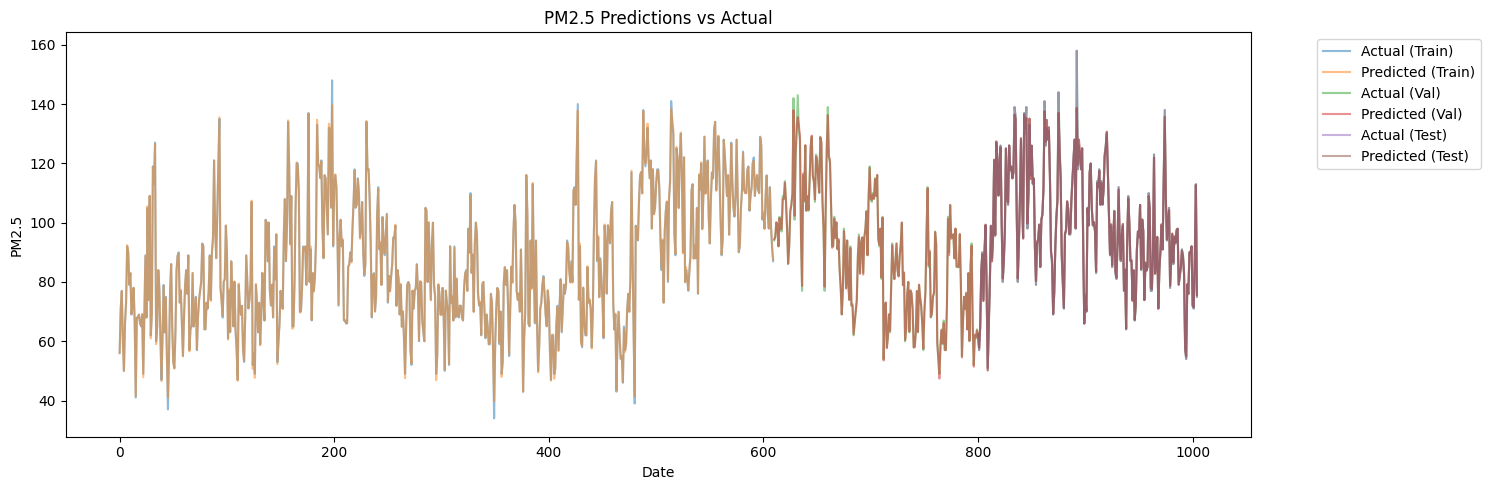

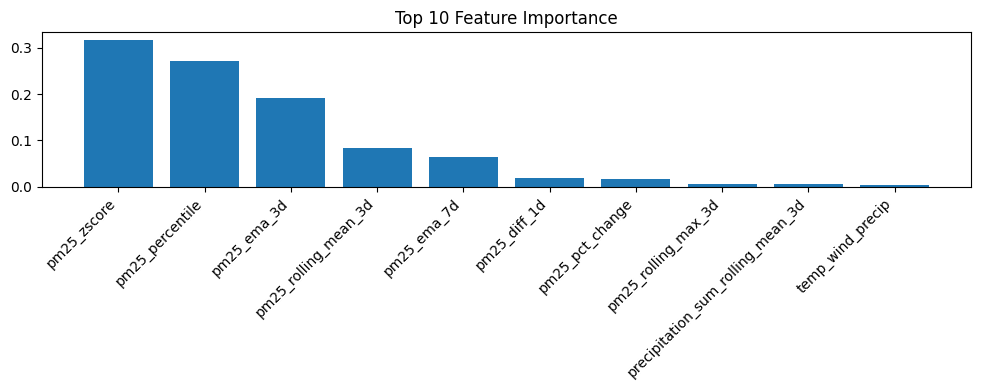

In [34]:
def evaluate_model(X, y, set_name):
    predictions = xgb_regressor.predict(X)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, predictions)
    print(f"\n{set_name} Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.4f}")
    return predictions

# Evaluate on all sets
train_pred = evaluate_model(train_features, y_train, "Training")
val_pred = evaluate_model(validation_features, y_validation, "Validation")
test_pred = evaluate_model(test_features, y_test, "Test")

# Create the time series plot
plt.figure(figsize=(15, 5))

# Plot training data and predictions
plt.plot(y_train.index, y_train.values, label='Actual (Train)', alpha=0.5)
plt.plot(y_train.index, train_pred, label='Predicted (Train)', alpha=0.5)

# Plot validation data and predictions
plt.plot(y_validation.index, y_validation.values, label='Actual (Val)', alpha=0.5)
plt.plot(y_validation.index, val_pred, label='Predicted (Val)', alpha=0.5)

# Plot test data and predictions
plt.plot(y_test.index, y_test.values, label='Actual (Test)', alpha=0.5)
plt.plot(y_test.index, test_pred, label='Predicted (Test)', alpha=0.5)

# Customize the plot
plt.title('PM2.5 Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Optional: Add feature importance plot
importance_df = pd.DataFrame({
    'feature': train_features.columns,
    'importance': xgb_regressor.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 4))
plt.bar(range(len(importance_df['importance'][:10])), importance_df['importance'][:10])
plt.xticks(range(len(importance_df['feature'][:10])), importance_df['feature'][:10], rotation=45, ha='right')
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

In [35]:
#pip install shap

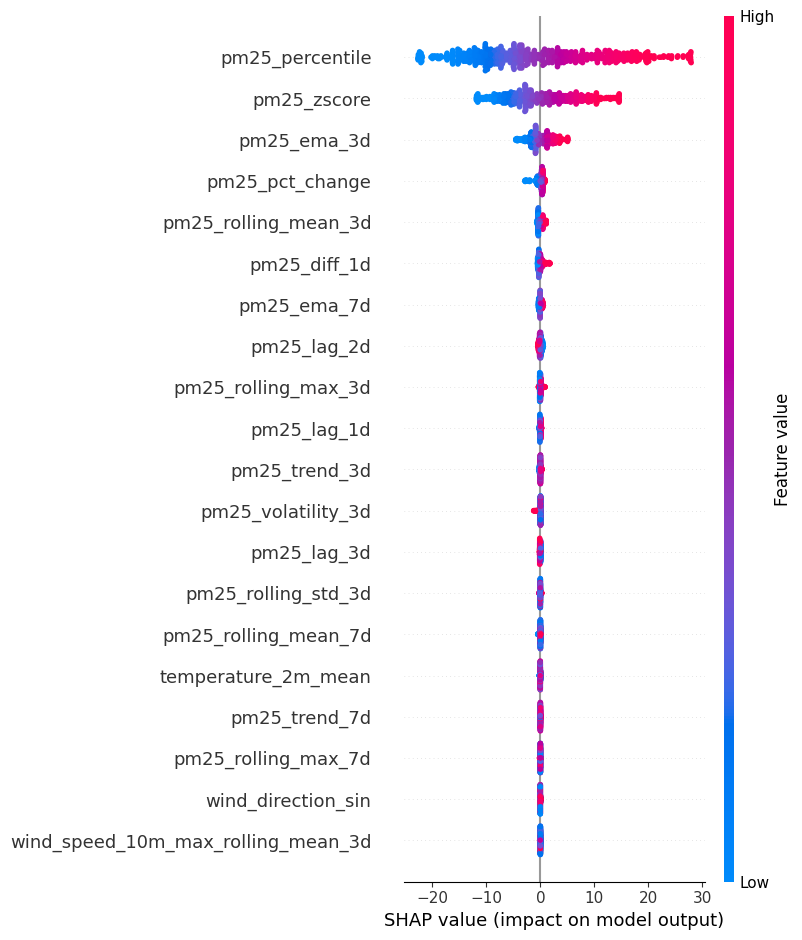

,feature,mean_abs_shap
17,pm25_trend_14d,0.007040
4,pm25_rolling_std_7d,0.007026
32,precipitation_sum_rolling_mean_3d,0.006959
20,pm25_volatility_14d,0.006874
35,temp_precip_interaction,0.005462
31,temperature_2m_mean_rolling_mean_3d,0.005285
30,wind_direction_10m_dominant,0.004355
24,month,0.004333
28,precipitation_sum,0.004029
39,wind_efficiency,0.003649


In [36]:
import shap

explainer = shap.Explainer(xgb_regressor)
shap_values = explainer(train_features)
shap.summary_plot(shap_values, train_features)

# Force plot for the first observation
shap.force_plot(
    explainer.expected_value,     # Scalar expected value
    shap_values.values[0, :],     # SHAP values for the first sample
    train_features.iloc[0, :]     # Feature values for the first sample
)

# Dependence plot for a specific feature
#shap.dependence_plot(
#    "pm25_rolling_mean_3d", 
#    shap_values.values, 
#    train_features
#)

# Feature importance DataFrame
shap_importance = pd.DataFrame({
    'feature': train_features.columns,
    'mean_abs_shap': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='mean_abs_shap', ascending=False)

shap_importance.tail(20)




In [37]:
#top_features = shap_importance['feature'][:20]  # Retain top 20 features

#train_features_trimmed = train_features[top_features]
#validation_features_trimmed = validation_features[top_features]
#test_features_trimmed = test_features[top_features]

#train_features_trimmed

In [38]:
# Predicting target values on the test set
#y_pred = xgb_regressor_trimmed.predict(test_features_trimmed)

# Calculating Mean Squared Error (MSE) using sklearn
#mse_trimmed = mean_squared_error(y_test.iloc[:,0], y_pred)
#print("MSE:", mse)

# Calculating R squared using sklearn
#r2_trimmed = r2_score(y_test.iloc[:,0], y_pred)
#print("R squared:", r2)

In [39]:
#xgb_regressor_trimmed = XGBRegressor(
#    max_depth=3,                # Further reduced to limit model complexity
#    learning_rate=0.005,        # Even smaller learning rate for better generalization
#   n_estimators=3000,          # Increased to compensate for smaller learning rate
#    subsample=0.6,              # Further reduced to increase randomization
#    colsample_bytree=0.6,       # Further reduced to increase randomization
#   min_child_weight=10,        # Increased to require more observations per leaf
#    reg_alpha=0.5,              # Increased L1 regularization
#    reg_lambda=2.0,             # Increased L2 regularization
#    gamma=0.4,                  # Increased minimum loss reduction
#    random_state=42
#)

# Fit with more aggressive early stopping
#xgb_regressor_trimmed.fit(
#    train_features_trimmed, 
#    y_train,
#    eval_set=[(train_features_trimmed, y_train), (validation_features_trimmed, y_validation)],
#    early_stopping_rounds=50,    # More aggressive early stopping
#    eval_metric='rmse',
#    verbose=100
#)

In [40]:
#def evaluate_model(X, y, set_name):
#    predictions = xgb_regressor_trimmed.predict(X)
#    mse = mean_squared_error(y, predictions)
#    rmse = np.sqrt(mse)
#    r2 = r2_score(y, predictions)
#    print(f"\n{set_name} Metrics:")
#    print(f"MSE: {mse:.2f}")
#    print(f"RMSE: {rmse:.2f}")
#   print(f"R2: {r2:.4f}")
#    return predictions

# Evaluate on all sets
#train_pred = evaluate_model(train_features_trimmed, y_train, "Training")
#val_pred = evaluate_model(validation_features_trimmed, y_validation, "Validation")
#test_pred = evaluate_model(test_features_trimmed, y_test, "Test")

# Create the time series plot
#plt.figure(figsize=(15, 5))

# Plot training data and predictions
#plt.plot(y_train.index, y_train.values, label='Actual (Train)', alpha=0.5)
#plt.plot(y_train.index, train_pred, label='Predicted (Train)', alpha=0.5)

# Plot validation data and predictions
#plt.plot(y_validation.index, y_validation.values, label='Actual (Val)', alpha=0.5)
#plt.plot(y_validation.index, val_pred, label='Predicted (Val)', alpha=0.5)

# Plot test data and predictions
#plt.plot(y_test.index, y_test.values, label='Actual (Test)', alpha=0.5)
#plt.plot(y_test.index, test_pred, label='Predicted (Test)', alpha=0.5)

# Customize the plot
#plt.title('PM2.5 Predictions vs Actual')
#plt.xlabel('Date')
#plt.ylabel('PM2.5')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.tight_layout()
#plt.show()

# Optional: Add feature importance plot
#importance_df = pd.DataFrame({
#    'feature': train_features_trimmed.columns,
#    'importance': xgb_regressor_trimmed.feature_importances_
#}).sort_values('importance', ascending=False)

#plt.figure(figsize=(10, 4))
#plt.bar(range(len(importance_df['importance'][:10])), importance_df['importance'][:10])
#plt.xticks(range(len(importance_df['feature'][:10])), importance_df['feature'][:10], rotation=45, ha='right')
#plt.title('Top 10 Feature Importance')
#plt.tight_layout()
#plt.show()


In [41]:
df = y_test
df['predicted_pm25'] = y_pred

In [42]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
800,62.0,62.322395,2024-04-16 00:00:00+00:00
801,57.0,57.804905,2024-04-18 00:00:00+00:00
802,65.0,64.654610,2024-04-19 00:00:00+00:00
803,84.0,83.651802,2024-04-20 00:00:00+00:00
804,90.0,89.274445,2024-04-21 00:00:00+00:00


In [43]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model_improved"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

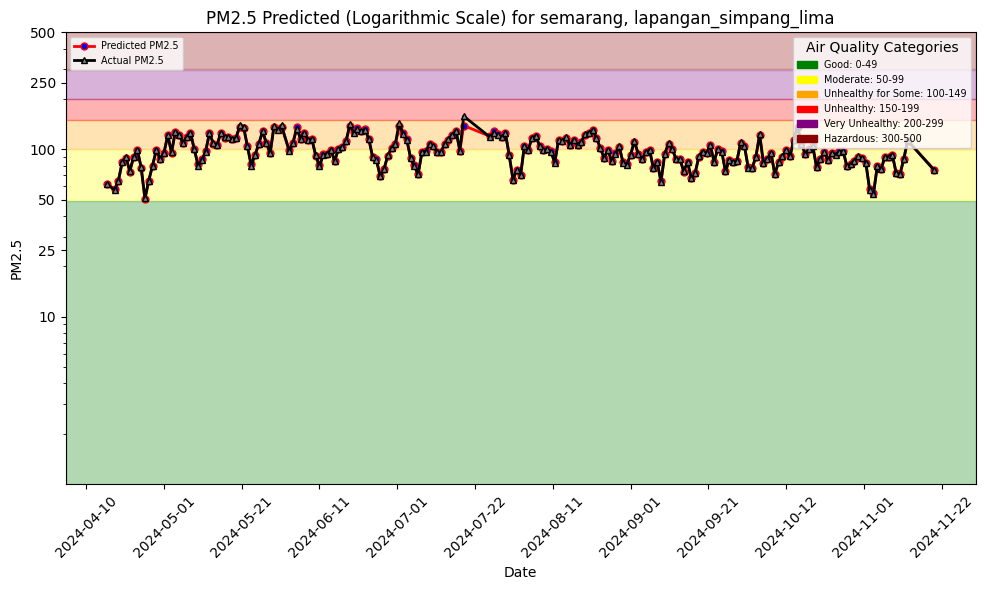

In [44]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

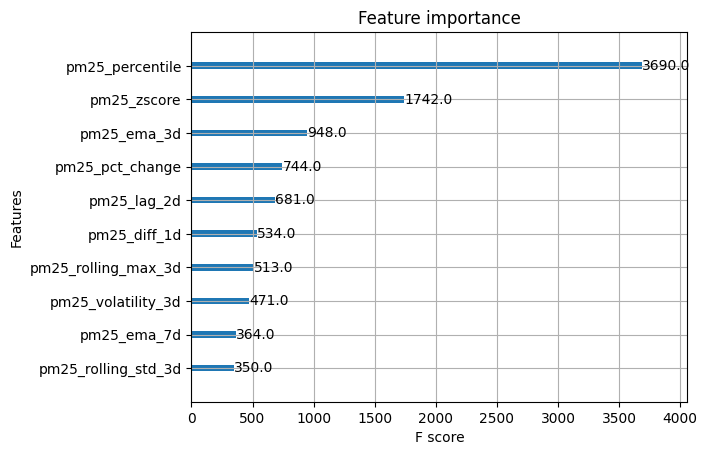

In [46]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=10)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [47]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [48]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [49]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [50]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model_improved", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/2562859 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/34387 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/81490 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/718 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/3759 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1159320/models/air_quality_xgboost_model_improved/3


Model(name: 'air_quality_xgboost_model_improved', version: 3)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
